In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm

from External.ICT.calculate_ICT import calculate_ICT
from External.clustering import centers
from External.generation import create_graph
from External.plotting import plot_points, plot_graph, no_intersections


plt.style.use('an.mplstyle')

In [5]:
# Hyperparameters
mode = "K_Nearest"
metric = "euclidean"
dataset = "non_convex"
ICT_algorithm = "cluster_all2"

# image loading
n = number_of_nodes = 1000
Random = False
image_name = "image"

# for the filename
parameters = "2-0_5-1000"

In [6]:
from copy import deepcopy
import operator

def find_backbone(old_ICT, number_of_vertices=0):
    
    #TODO for many vertices min_max_priority queue better...
    
    high_vertices = [[0, None, None]]
    backbone_nodes = set()
    
    ICT = deepcopy(old_ICT)
    
    initials = [0,0]

    Backbone = nk.Graph(n=G.numberOfNodes(), weighted=True)

    bc = nk.centrality.Betweenness(ICT, normalized=True, computeEdgeCentrality=True)
    bc.run()
    ICT_centralities = bc.edgeScores()

    seed = np.argmax(ICT_centralities)
    seed

    for u, v in ICT.iterEdges():
        eid = ICT.edgeId(u, v)
        ICT.setWeight(u, v, ICT_centralities[eid])
        if eid == seed:
            initials[0] = u
            initials[1] = v
            Backbone.addEdge(u, v, ICT_centralities[eid])
            backbone_nodes.add(u)
            backbone_nodes.add(v)

    # Go the tree up and down
    for i in range(2):
        node = initials[i]
        last = initials[(i+1)%2]
        while True:
            max_w = 0

            neighbors = list(ICT.iterNeighbors(node))

            # find the edge that belongs to the backbone as well
            for neighbor in neighbors:
                w = ICT.weight(node, neighbor)
                if w > max_w and neighbor != last:
                    max_w = w
                    keep = neighbor

            Backbone.addEdge(node, keep, max_w)
            backbone_nodes.add(keep)

            # Mark the largest vertices
            for neighbor in neighbors:
                if (neighbor != last) and (neighbor != keep):
                    vertex_weight = ICT.weight(node, neighbor)
                    if number_of_vertices > 0 and vertex_weight > high_vertices[-1][0]:
                        high_vertices.append([vertex_weight, node, neighbor])
                        high_vertices.sort(key = operator.itemgetter(0), reverse=True)
                    if len(high_vertices) > number_of_vertices:
                        high_vertices.pop()

            last = node
            node = keep

            if ICT.degree(node)==1:
                break
            if ICT.degree(last)==1:
                break
         
        
        
    while(number_of_vertices > 0):
        number_of_vertices -= 1
        max_w, last, node = high_vertices.pop(0)
        Backbone.addEdge(last, node, max_w)
        backbone_nodes.add(node)
        
        
        while True:
            max_w = 0

            neighbors = list(ICT.iterNeighbors(node))

            # find the edge that belongs to the backbone as well
            for neighbor in neighbors:
                w = ICT.weight(node, neighbor)
                if w > max_w and neighbor != last:
                    max_w = w
                    keep = neighbor

            Backbone.addEdge(node, keep, max_w)
            backbone_nodes.add(keep)

            # Mark the largest vertices
            for neighbor in neighbors:
                if (neighbor != last) and (neighbor != keep):
                    vertex_weight = ICT.weight(node, neighbor)
                    if  number_of_vertices > 0 and vertex_weight > high_vertices[-1][0]:
                        high_vertices.append([vertex_weight, node, neighbor])
                        high_vertices.sort(key = operator.itemgetter(0), reverse=True)
                    if len(high_vertices) > number_of_vertices:
                        high_vertices.pop()

            last = node
            node = keep

            if ICT.degree(node)==1:
                break
            if ICT.degree(last)==1:
                break
    

    return Backbone, np.sort(list(backbone_nodes))

In [7]:
def load_image(filename):
    a=plt.imread(filename+'.png')
    rgb_weights = [0.2989, 0.5870, 0.1140]
    
    grayscale_image = np.dot(a[...,:3], rgb_weights)>0
    
    return grayscale_image
    
    
def sample_points_from_image(n,img,Random=True):
    if not Random:
        random.seed(42)
    non_zero = np.where(img!=0)
    # non_zero=np.vstack((non_zero[0],non_zero[1])).T
    
    
    idx = random.sample(range(len(non_zero[0])),n)
    
    x_coord = non_zero[0][idx]
    y_coord = non_zero[1][idx]
    return x_coord,y_coord

sklearn is done: 1.03794264793396
My own part is done: 0.004653453826904297
Final k: 11


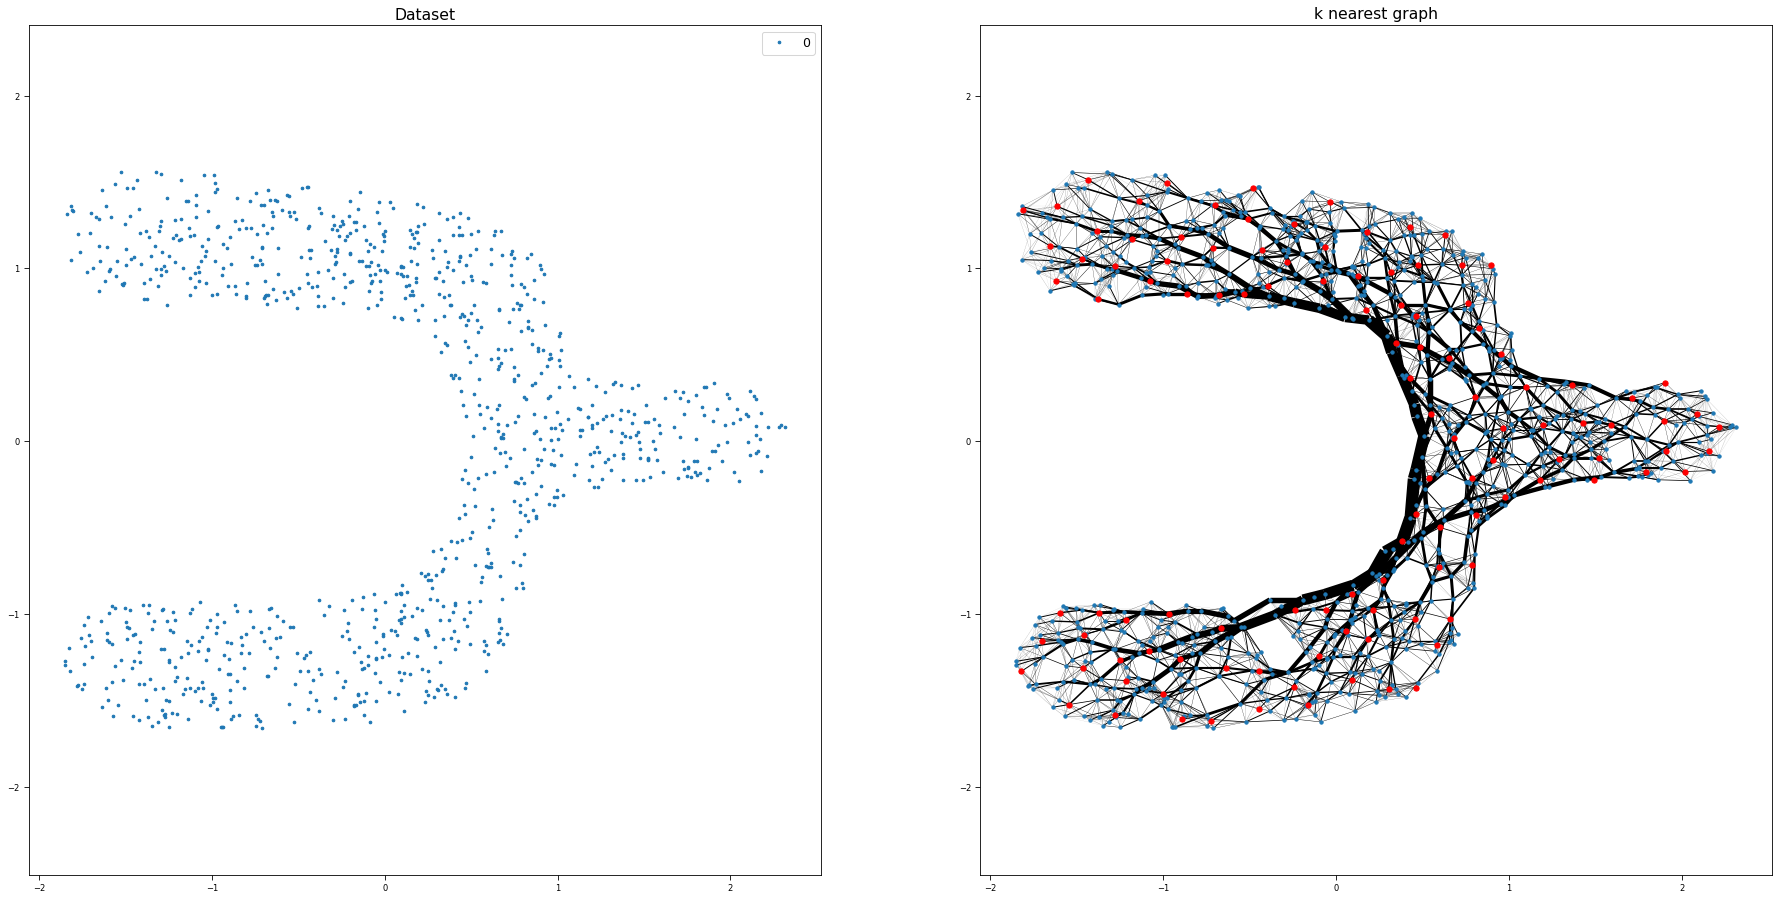

In [8]:
# Compute the position array
img = load_image(image_name)
position = np.array(sample_points_from_image(n,img,Random)).T
position = StandardScaler().fit_transform(position)

# Compute knearest graph
cluster_centers = centers(position)
G, _ = create_graph(number_of_nodes, mode, position=position, beta=2, delta=0.5)
G.indexEdges()

# Plot the prepared data
fig, axs = plt.subplots(1, 2)
plot_points(position, "Dataset", axs[0])
plot_graph(G, position, "k nearest graph", axs[1], cluster_centers)
plt.show()


d = pairwise_distances(position)
d[d==0] = np.inf
min_distance = np.min(d, axis=0)
avg_distance = np.mean(min_distance)
threshold = 10 * avg_distance

In [9]:
node_weights = np.ones(G.upperNodeIdBound())
ICT = calculate_ICT(G, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers, node_weights=node_weights,
                                zeros_stay_zeros=True, update_G=1.1)
ICT.indexEdges()

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

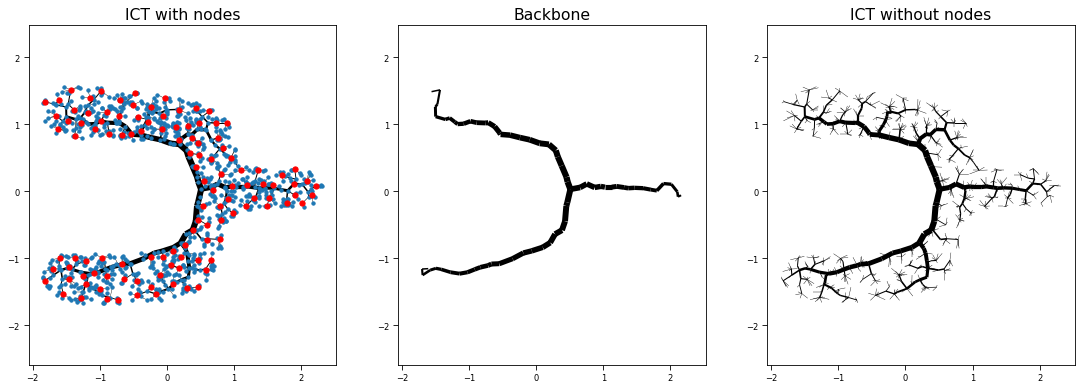

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

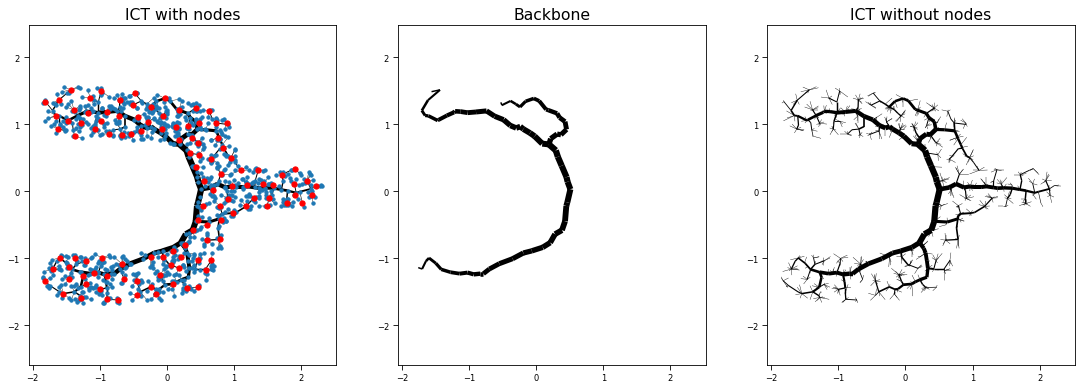

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

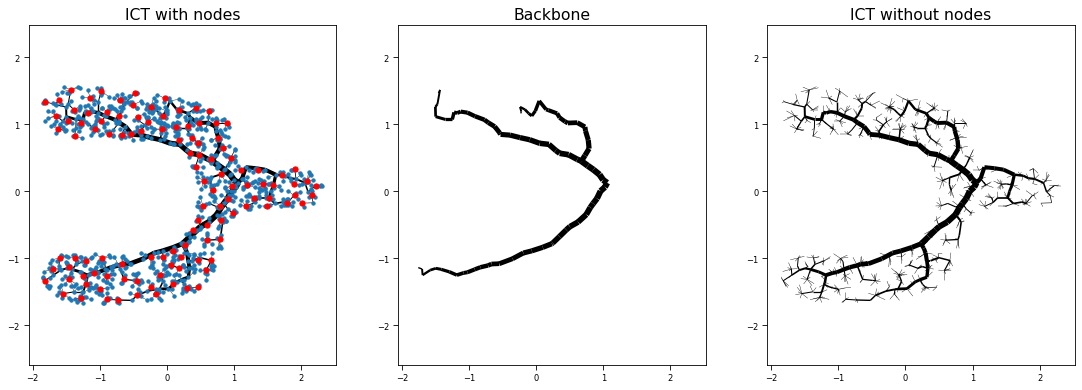

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

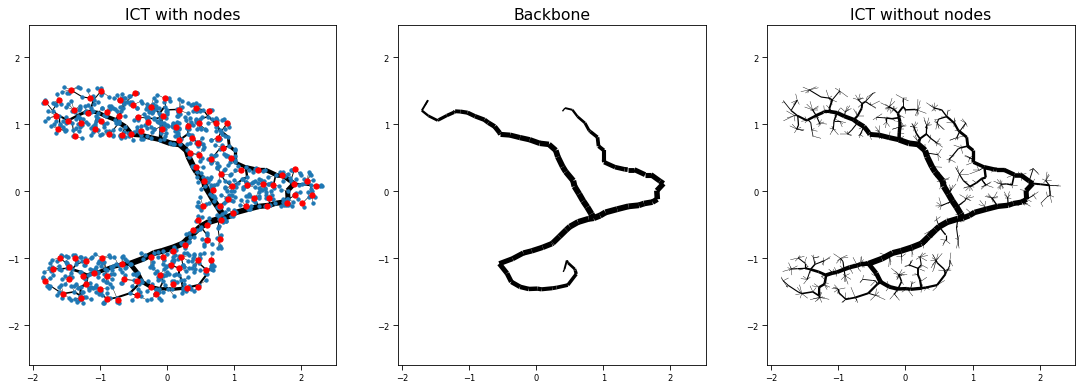

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

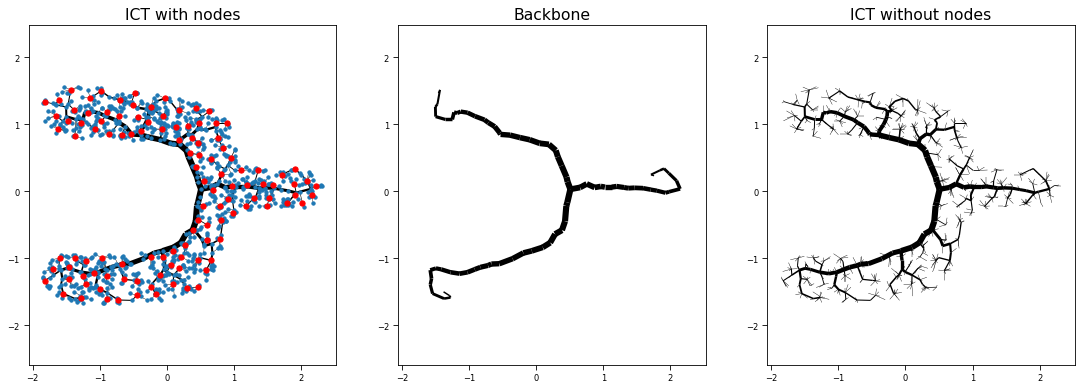

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

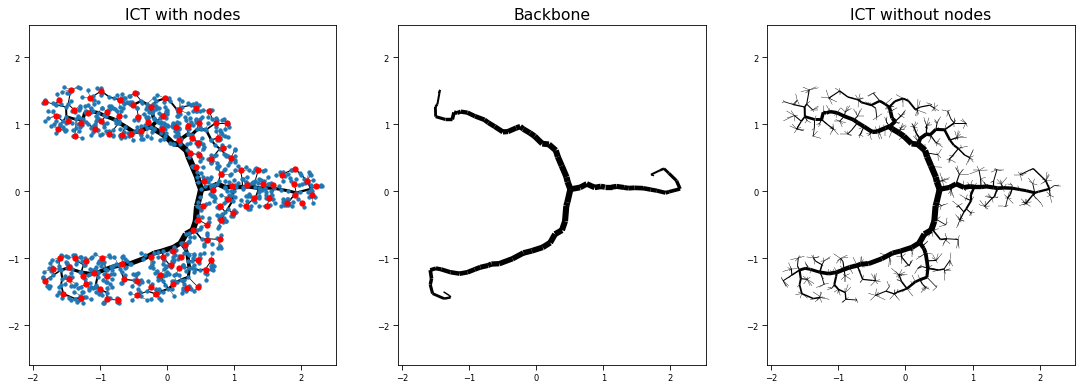

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

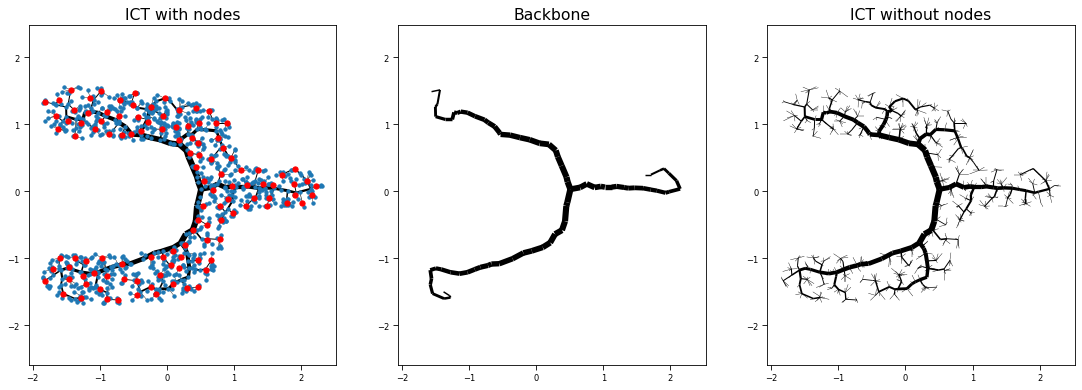

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

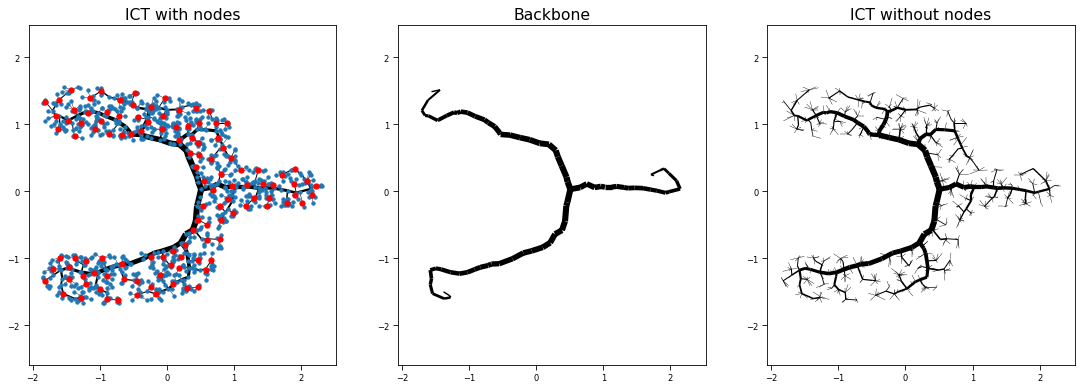

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

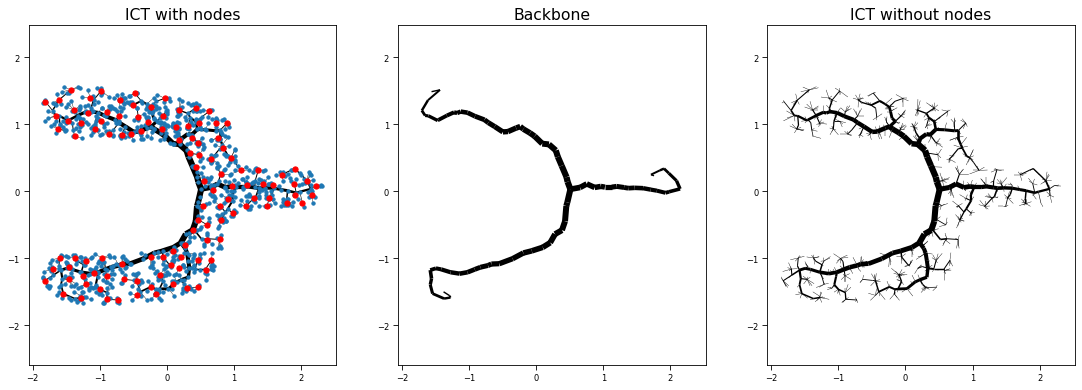

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

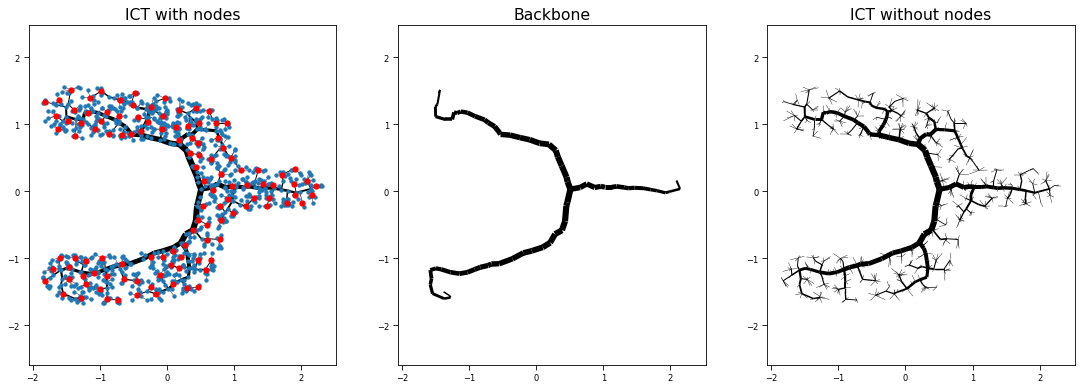

create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

In [10]:
for iteration in range(10):

    good = []
    
    Backbone, backbone_nodes = find_backbone(ICT, 1)
    Backbone.indexEdges()
    
    for u in ICT.iterNodes():
        if ICT.degree(u)==1:
            good.append(u)
            
    distances = pairwise_distances(position[good], position[backbone_nodes])
    
    distances_without_zeros = np.array(distances)
    distances_without_zeros[distances_without_zeros==0] = np.inf
    
    normalize = np.min(distances_without_zeros)
    for idx, node in enumerate(good):
        node_weights[node] += (np.min(distances[idx])/normalize) ** 2
        
    # Plot the ICT
    fig, axs = plt.subplots(1, 3, figsize=(18,6))
    plot_graph(ICT, position, "ICT with nodes", axs[0], cluster_centers, edge_scale=0.5)
    plot_graph(Backbone, position, "Backbone", axs[1], node_size=0, edge_scale=0.5)
#     plot_points(position[np.argwhere(node_weights>1).T[0]], "Reweighted points", axs[1])
    plot_graph(ICT, position, "ICT without nodes", axs[2], node_size=0, edge_scale=0.5)
    plt.savefig("./Output/" + str(iteration) + ".png")
    plt.show()

#     # Compute knearest graph
#     G, _ = create_graph(number_of_nodes, mode, position=position, beta=2, delta=0.5)
#     G.indexEdges()

    ICT = calculate_ICT(G, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers, node_weights=node_weights,
                                    zeros_stay_zeros=True, update_G=1.1)
    ICT.indexEdges()

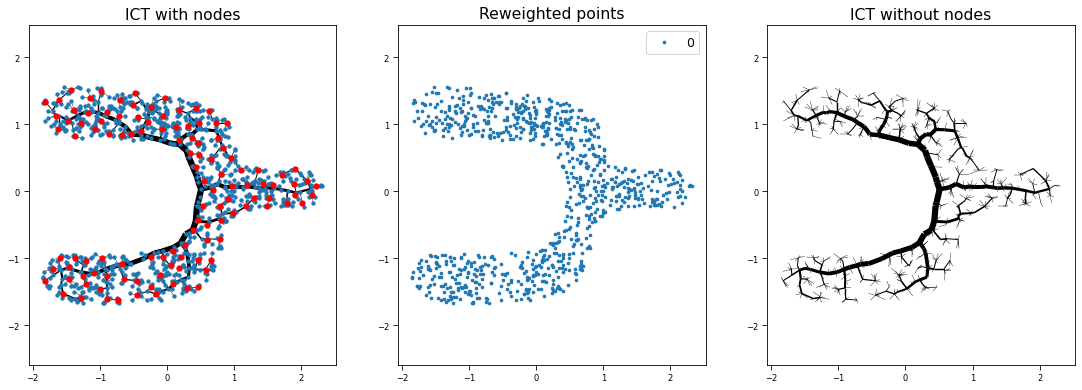

In [11]:
# Plot the ICT
fig, axs = plt.subplots(1, 3, figsize=(18,6))
plot_graph(ICT, position, "ICT with nodes", axs[0], cluster_centers, edge_scale=0.5)
plot_points(position[np.argwhere(node_weights>1).T[0]], "Reweighted points", axs[1])
plot_graph(ICT, position, "ICT without nodes", axs[2], node_size=0, edge_scale=0.5)
plt.savefig("./Output/" + str(iteration) + ".png")
plt.show()